# Import Packages and Load Data

In [69]:
!pip install category_encoders

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
dataframe = pd.read_csv('drive/MyDrive/spotify_billboard_2.csv', index_col=False)

In [73]:
dataframe.shape

(40820, 23)

#Preprocessing

## Data Wrangling

In [74]:
df = dataframe

In [75]:
df_test = df[df['billboard_appearance'] == 1]

In [76]:
df = df.set_index('id')

In [77]:
# drop columns not needed for model
df = df.drop(['Unnamed: 0', 'release_date', 'name', 'song_id', 'artists', 'year'], axis=1)

In [78]:
df.head(1)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,primary_artist,billboard_appearance
id,,,,,,,,,,,,,,,,
03TzvVWdkVbLT9pzewYiDw,0.0785,0.587,200733,0.635,1,0.0,8,0.175,-6.369,1,64,0.422,82.517,0.758,lil wayne,0


In [79]:
explicit_onehot = pd.get_dummies(df.explicit, prefix='explicit')
key_onehot = pd.get_dummies(df.key, prefix='key')
mode_onehot = pd.get_dummies(df['mode'], prefix='mode')
df = pd.concat([df,explicit_onehot, key_onehot, mode_onehot],axis=1)
df = df.drop(columns=['key','mode','explicit'])

In [80]:
df.head(1)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,primary_artist,billboard_appearance,explicit_0,explicit_1,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
03TzvVWdkVbLT9pzewYiDw,0.0785,0.587,200733,0.635,0.0,0.175,-6.369,64,0.422,82.517,0.758,lil wayne,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [81]:
# Target encode the artist 

encoder = TargetEncoder()
df['Artist_Encoded'] = encoder.fit_transform(df['primary_artist'],df['popularity'])

df = df.drop(columns='primary_artist')

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [82]:
df.head(1)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,billboard_appearance,explicit_0,explicit_1,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,Artist_Encoded
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
03TzvVWdkVbLT9pzewYiDw,0.0785,0.587,200733,0.635,0.0,0.175,-6.369,64,0.422,82.517,0.758,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,51.266667


In [83]:
df.shape

(40820, 29)

In [84]:
numericalFeatures = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness', 'popularity', 'speechiness','tempo','valence']

In [85]:
min_max_scaler = MinMaxScaler()
df[numericalFeatures] = min_max_scaler.fit_transform(df[numericalFeatures])

In [86]:
df_test = df[df['billboard_appearance'] == 1]
df_test.shape

(5347, 29)

## Initialize train, validation, and test data

In [87]:
X = df.drop('billboard_appearance', axis=1)

In [88]:
y = df['billboard_appearance']

In [89]:
X_non_test , X_test , y_non_test, y_test = train_test_split(X,y,test_size=0.2)

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.185)

In [91]:
#Perfrom undersampling for improved training
re_sampler = RandomUnderSampler()
X_train, y_train = re_sampler.fit_resample(X_train, y_train)
X_val, y_val = re_sampler.fit_resample(X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#Dimensionality Reduction

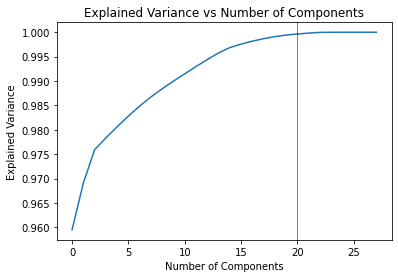

In [92]:
pca = PCA()
pca_X_train = pca.fit_transform(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance vs Number of Components')
plt.ylabel('Explained Variance')
plt.xlabel('Number of Components')
plt.axvline(x=20, lw=0.5, c='black')

In [93]:
pca = PCA(n_components=22)

X_train = pca.fit_transform(X_train)
X_val = pca.fit_transform(X_val)
X_test = pca.fit_transform(X_test)

#Model Building

##Helper Functions

In [94]:
# return all metrics for determining quality of model
def get_classification_metrics(actual, pred):
  print(confusion_matrix(actual, pred))
  print('Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}'.format(
      accuracy_score(actual, pred),
      precision_score(actual, pred),
      recall_score(actual, pred),
      f1_score(actual, pred)))

In [97]:
def hyp_tuning(model_list, param_grid_list, X_train, y_train, X_test, y_test):
    
    for i in range(len(model_list)):
        print(model_list[i])
        grid_search = GridSearchCV(model_list[i], param_grid_list[i], cv = 5, scoring = 'accuracy')
        grid_search.fit(X_train, y_train)
        print('Best Parameters: {}'.format(grid_search.best_params_))
        best_cross_val_score = grid_search.best_score_
        print('Best Cross Validation Score: {}'.format(best_cross_val_score))
        # Score on the test set
        test_score = grid_search.score(X_test, y_test)
        print('Validation Set Score: {}'.format(test_score))

##Logistic Regression

Hyperparameter Tuning

In [98]:
param_grid_logistic = {'C': [5, 6, 7, 8, 9, 10]}

model_list = [LogisticRegression(max_iter = 1000)]
param_grid_list = [param_grid_logistic]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_val, y_val)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters: {'C': 8}
Best Cross Validation Score: 0.6306884260393694
Validation Set Score: 0.5626283367556468


Fitting and Predicting

In [125]:
clf = LogisticRegression(C=8, random_state=0, max_iter=1000)
clf.fit(X_train, y_train)
y_train_pred_log = clf.predict(X_train)
y_val_pred_log = clf.predict(X_val)
y_test_pred_log = clf.predict(X_test)

In [126]:
# Save the predictions
log_predictions_train = y_train_pred_log
log_predictions_val = y_val_pred_log
log_predictions_test = y_test_pred_log

Classification Metrics

In [101]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_log)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_log)

Training
[[2299 2074]
 [1147 3226]]
Accuracy: 0.6317173565058313, Precision: 0.6086792452830189, Recall: 0.7377086668191173, F1 Score: 0.6670112684792723

Test
[[3505 3618]
 [ 354  687]]
Accuracy: 0.5134737873591376, Precision: 0.15958188153310104, Recall: 0.659942363112392, F1 Score: 0.2570145903479237


##Random Forest

Hyperparameter Tuning

In [104]:
# define hyperparameter grid
param_grid_rf = [
    {'max_depth': [9, 10, 11], 'n_estimators': [60, 70, 80]}
]

model_list = [RandomForestClassifier()]
param_grid_list = [param_grid_rf]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_val, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'max_depth': 10, 'n_estimators': 70}
Best Cross Validation Score: 0.6721932859593237
Validation Set Score: 0.5888090349075975


Fitting and Predicting

In [128]:
clf = RandomForestClassifier(max_depth=10, n_estimators=70)
clf.fit(X_train, y_train)
y_train_pred_rf = clf.predict(X_train)
y_val_pred_rf = clf.predict(X_val)
y_test_pred_rf = clf.predict(X_test)

In [129]:
# Save the predictions
rf_predictions_train = y_train_pred_rf
rf_predictions_val = y_val_pred_rf
rf_predictions_test = y_test_pred_rf

Classification Metrics

In [108]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_rf)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_rf)

Training
[[3034 1339]
 [ 252 4121]]
Accuracy: 0.8180882689229362, Precision: 0.7547619047619047, Recall: 0.9423736565286989, F1 Score: 0.8381979050137293

Test
[[4368 2755]
 [ 424  617]]
Accuracy: 0.6106075453209211, Precision: 0.18297746144721233, Recall: 0.5926993275696446, F1 Score: 0.27962837072286423


##Adaboost

Hyperparameter Tuning

In [109]:
param_grid_ada={'n_estimators':[90, 100, 110],'learning_rate':[0.2, 0.3, 0.4]}

model_list = [AdaBoostClassifier()]
param_grid_list = [param_grid_ada]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_val, y_val)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Best Parameters: {'learning_rate': 0.4, 'n_estimators': 100}
Best Cross Validation Score: 0.6639611206403659
Validation Set Score: 0.5734086242299795


Fitting and Predicting

In [130]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.4, random_state=20)
clf.fit(X_train, y_train)
y_train_pred_ada = clf.predict(X_train)
y_val_pred_ada = clf.predict(X_val)
y_test_pred_ada = clf.predict(X_test)

In [131]:
# Save the predictions
ada_predictions_train = y_train_pred_ada
ada_predictions_val = y_val_pred_ada
ada_predictions_test = y_test_pred_ada

Classification Metrics

In [112]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_ada)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_ada)

Training
[[2522 1851]
 [ 924 3449]]
Accuracy: 0.6827120969586097, Precision: 0.6507547169811321, Recall: 0.7887034072718957, F1 Score: 0.7131189910058926

Test
[[4637 2486]
 [ 480  561]]
Accuracy: 0.6366976972072513, Precision: 0.18411552346570398, Recall: 0.5389048991354467, F1 Score: 0.2744618395303327


##SVM

Hyperparameter Tuning

In [113]:
list_kernel_type = ['linear', 'poly', 'rbf']
random_state = 20

objs_KSVM = [SVC(kernel=kernel_type, random_state=random_state) for kernel_type in list_kernel_type]

for model in objs_KSVM:
  model.fit(X_train, y_train)
  print(model.score(X_test, y_test))

0.43214110730034294
0.31210191082802546
0.4710926016658501


Fitting and Predicting

In [132]:
clf = SVC(kernel='rbf', random_state=20)
clf.fit(X_train, y_train)
y_train_pred_svm = clf.predict(X_train)
y_val_pred_svm = clf.predict(X_val)
y_test_pred_svm = clf.predict(X_test)

In [133]:
# Save the predictions
svm_predictions_train = y_train_pred_svm
svm_predictions_val = y_val_pred_svm
svm_predictions_test = y_test_pred_svm

Classification Metrics

In [116]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_svm)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_svm)

Training
[[2075 2298]
 [ 882 3491]]
Accuracy: 0.6364052138120283, Precision: 0.6030402487476249, Recall: 0.7983077978504459, F1 Score: 0.6870694745128912

Test
[[3047 4076]
 [ 242  799]]
Accuracy: 0.4710926016658501, Precision: 0.16389743589743588, Recall: 0.7675312199807877, F1 Score: 0.27011494252873564


##kNN

Hyperparameter Tuning

In [117]:
param_grid_knn={'n_neighbors':[2,3,4]}

model_list = [KNeighborsClassifier()]
param_grid_list = [param_grid_knn]

hyp_tuning(model_list, param_grid_list, X_train, y_train, X_val, y_val)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Best Parameters: {'n_neighbors': 3}
Best Cross Validation Score: 0.6019908192436494
Validation Set Score: 0.5559548254620124


Fitting and Predicting

In [134]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_train_pred_knn = clf.predict(X_train)
y_val_pred_knn = clf.predict(X_val)
y_test_pred_knn = clf.predict(X_test)

In [135]:
# Save the predictions
knn_predictions_train = y_train_pred_knn
knn_predictions_val = y_val_pred_knn
knn_predictions_test = y_test_pred_knn

Classification Metrics

In [120]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_knn)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_knn)

Training
[[3312 1061]
 [ 707 3666]]
Accuracy: 0.797850445918134, Precision: 0.7755447429659403, Recall: 0.8383260919277384, F1 Score: 0.8057142857142857

Test
[[3421 3702]
 [ 395  646]]
Accuracy: 0.4981626653601176, Precision: 0.1485740570377185, Recall: 0.6205571565802114, F1 Score: 0.23974763406940064


#Ensemble

##Dataframe Assembly

In [136]:
# initialize dataframe of supervised results with log predictions
supervised_train_df = pd.DataFrame(log_predictions_train, columns = ['log_predictions_train'])
supervised_train_df['rf_predictions_train'] = rf_predictions_train
supervised_train_df['ada_predictions_train'] = ada_predictions_train
supervised_train_df['svm_predictions_train'] = svm_predictions_train
supervised_train_df['knn_predictions_train'] = knn_predictions_train

In [137]:
# initialize dataframe of supervised results with log predictions
supervised_val_df = pd.DataFrame(log_predictions_val, columns = ['log_predictions_val'])
supervised_val_df['rf_predictions_val'] = rf_predictions_val
supervised_val_df['ada_predictions_val'] = ada_predictions_val
supervised_val_df['svm_predictions_val'] = svm_predictions_val
supervised_val_df['knn_predictions_val'] = knn_predictions_val

In [138]:
# initialize dataframe of supervised results with log predictions
supervised_test_df = pd.DataFrame(log_predictions_test, columns = ['log_predictions_test'])
supervised_test_df['rf_predictions_test'] = rf_predictions_test
supervised_test_df['ada_predictions_test'] = ada_predictions_test
supervised_test_df['svm_predictions_test'] = svm_predictions_test
supervised_test_df['knn_predictions_test'] = knn_predictions_test

In [139]:
supervised_train_df.head()

,log_predictions_train,rf_predictions_train,ada_predictions_train,svm_predictions_train,knn_predictions_train
0,0,0,1,1,0
1,0,0,0,0,1
2,0,0,0,0,0
3,1,1,1,1,0
4,1,0,0,1,0


In [140]:
supervised_val_df.head()

,log_predictions_val,rf_predictions_val,ada_predictions_val,svm_predictions_val,knn_predictions_val
0,0,0,0,0,0
1,0,0,1,1,1
2,1,0,1,1,1
3,1,1,1,1,1
4,1,1,1,1,0


In [141]:
supervised_test_df.head()

,log_predictions_test,rf_predictions_test,ada_predictions_test,svm_predictions_test,knn_predictions_test
0,1,1,0,1,1
1,1,0,0,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,0,0,0,0,1


##Random Forest on Individual Learners

In [148]:
# define hyperparameter grid
param_grid_rf = [
    {'max_depth': [4, 5], 'n_estimators': [20, 30]}
]

model_list = [RandomForestClassifier()]
param_grid_list = [param_grid_rf]

hyp_tuning(model_list, param_grid_list, supervised_train_df, y_train, supervised_val_df, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best Parameters: {'max_depth': 5, 'n_estimators': 30}
Best Cross Validation Score: 0.8647373356203545
Validation Set Score: 0.580082135523614


In [149]:
clf = RandomForestClassifier(max_depth=5, n_estimators=30)
clf.fit(supervised_train_df, y_train)
y_train_pred_ensemble = clf.predict(supervised_train_df)
y_test_pred_ensemble = clf.predict(supervised_test_df)

In [150]:
# Classification metrics for training data
print('Training')
get_classification_metrics(y_train, y_train_pred_ensemble)

print("")

# Classification metrics for test data
print('Test')
get_classification_metrics(y_test, y_test_pred_ensemble)

Training
[[3824  549]
 [ 634 3739]]
Accuracy: 0.8647381660187514, Precision: 0.8719682835820896, Recall: 0.8550194374571233, F1 Score: 0.8634106916060501

Test
[[4956 2167]
 [ 554  487]]
Accuracy: 0.6667074963253308, Precision: 0.18349660889223812, Recall: 0.4678194044188281, F1 Score: 0.26359945872801077
